In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import wordcloud

import spacy
#spacy.cli.download("it_core_news_sm")
ITA_tokenizer = spacy.load("it_core_news_sm", disable=['parser', 'ner'])

num_topics = 3

it_stop_words = []#stopwords.words('italian')
custom_stop_words = ['me','xe', 'el', 'lettera', 'schmitz','ettore', 'signora', 'signore', 'scrivere', 'sapere','fare', 'cosa','essere']
it_stop_words.extend(custom_stop_words)
full_corpus = pd.read_csv('carteggio_svevo3.csv', sep=';')
ita_corpus = full_corpus[full_corpus['mainLanguage'] == 'ITA'].reset_index()
ita_corpus_tfidf = full_corpus[full_corpus['mainLanguage'] == 'ITA'].reset_index()

Following the text of the project proposal the goal is to find:
- which are the main topics of discussion in the corpus, who are the people which each topic is more associated with, how does the interest on different topics evolve over the time

In [2]:
def pre_proc(text, pos = ['PROPN', 'NOUN', 'VERB'], stop_words = it_stop_words ):
    #for the tokenization part we used a piece of software from spacy that performs tokenization, lemmatization
    #and pos tagging in one shot
    
    text = text.lower()
    doc = ITA_tokenizer(text)
    tokenized_text = []
    #tokenizing and lemmatizing on one shot
    for token in doc:
        if token.lemma_ not in stop_words and token.pos_ in pos and not token.is_stop and token.is_alpha:
            tokenized_text.append(token.lemma_)
            #print(token.pos_)
    return tokenized_text

def extract_topic_keywords(model, num_words, plot = True):
    #extracting for each topic the keywords and making some plots
    num_topics = len(model.print_topics())
    if plot:
        for t,w  in model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words):
            
            print("Topic {} keywords:\n\n format['word','frequency']\n\n {}".format(t,w))

            w = dict(w)
            width = 800
            height = 600

            wcloud = wordcloud.WordCloud(width = width, height = height, background_color='White').generate_from_frequencies(w)
            plt.figure(dpi=150)
            plt.imshow(wcloud)
            plt.axis('off')
            plt.show()
    
    
    return [[tup2[0] for tup2 in tup[1]]for tup in model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words)]

def get_topic_scores(model, bow_corpus):
    #getting for each topic the score assigned for each topic
    corpus_scores = []
    for letter in bow_corpus:
        score = [0 for i in range(num_topics)]
        model_output =  model[letter]
        
        for out in model_output:
            i = out[0]
            score[i] = out[1]
        
        corpus_scores.append(score)
    return corpus_scores

def get_coherence(model, corpus, dictionary, pp = False):
    
    c_av = models.CoherenceModel(model=model, corpus = bow,  dictionary=dictionary, coherence='u_mass').get_coherence()
    c_per_topic = models.CoherenceModel(model=model, corpus = bow,  dictionary=dictionary, coherence='u_mass').get_coherence_per_topic()
    if pp:
        print("Model av. coherence\tTopic scores")
        print("-------------------\t------------")
        print("{}\t{}".format(c_av, c_per_topic))
    return c_av,np.array(c_per_topic)

In [3]:
sender = ita_corpus['sender']
recipient = ita_corpus['recipient']
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']
sr = []
for i in range(len(sender)):
    if sender[i] != 'Ettore Schmitz' and sender[i] in important_people:
        sr.append(sender[i])
    elif recipient[i] in important_people:
        sr.append(recipient[i])
    else:
        sr.append('OTHER')
ita_corpus['SR'] = sr  
ita_corpus['SR'].value_counts()

Livia Veneziani               608
OTHER                          63
Eugenio Montale                62
Paul Henri Michel              17
Valerio Jahier                 15
Marieanne Crémieux Comnène     14
James Joyce                    13
Giuseppe Prezzolini            12
Ferdinando Pasini              11
Valéry Larbaud                 11
Name: SR, dtype: int64

In [4]:
sender = ita_corpus_tfidf['sender']
recipient = ita_corpus_tfidf['recipient']
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']
sr = []
for i in range(len(sender)):
    if sender[i] != 'Ettore Schmitz' and sender[i] in important_people:
        sr.append(sender[i])
    elif recipient[i] in important_people:
        sr.append(recipient[i])
    else:
        sr.append('OTHER')
ita_corpus_tfidf['SR'] = sr  
ita_corpus_tfidf['SR'].value_counts()

Livia Veneziani               608
OTHER                          63
Eugenio Montale                62
Paul Henri Michel              17
Valerio Jahier                 15
Marieanne Crémieux Comnène     14
James Joyce                    13
Giuseppe Prezzolini            12
Ferdinando Pasini              11
Valéry Larbaud                 11
Name: SR, dtype: int64

In [5]:
processed_letters = []
for letter in ita_corpus['text']:
    

    tokenized_letter = pre_proc(letter,pos = ['PROPN', 'NOUN', 'VERB'])
    processed_letters.append(tokenized_letter)
  

In [6]:
import gensim
pure_dictionary = gensim.corpora.Dictionary(processed_letters)

dictionary = gensim.corpora.Dictionary(processed_letters)
dictionary.filter_extremes(no_below=5, no_above=0.5)

dictionary_for_tfidf = gensim.corpora.Dictionary(processed_letters)

pruned_dictionary_for_tfidf = gensim.corpora.Dictionary(processed_letters)
pruned_dictionary_for_tfidf.filter_extremes(no_below=5, no_above=0.5)

In [7]:
pure_bow = [pure_dictionary.doc2bow(doc) for doc in processed_letters] 

bow = [dictionary.doc2bow(doc) for doc in processed_letters]

bow_for_tfidf=[dictionary_for_tfidf.doc2bow(doc) for doc in processed_letters]

bow_for_pruned_tfidf=[pruned_dictionary_for_tfidf.doc2bow(doc) for doc in processed_letters]

from gensim import corpora, models

tfidf = models.TfidfModel(bow_for_tfidf)
corpus_for_tfidf = tfidf[bow_for_tfidf]

pruned_tfidf = models.TfidfModel(bow_for_pruned_tfidf)
corpus_for_pruned_tfidf = tfidf[bow_for_pruned_tfidf]

In [22]:
max_n_topics = 10
coherency_scores = np.zeros([max_n_topics,4])
whole_coherency_scores = []
take_measures = True

if take_measures:
    
    
    for n in range(1,max_n_topics + 1):
        print("Calculating coherence scores for {} topics".format(n))
        #learn a model without pruning the dictionary
        lda_model_unpruned = gensim.models.LdaMulticore(pure_bow, num_topics=n, id2word=pure_dictionary, passes=10)
        #learn a model pruning the dictionary
        lda_model_pruned = gensim.models.LdaMulticore(bow, num_topics=n, id2word=dictionary, passes=10)
        #learn a model with tf_idf
        lda_model_tfidf = gensim.models.LdaMulticore(corpus_for_tfidf, num_topics=n, id2word=dictionary_for_tfidf, passes=10)
        #learn a model with tf_idf on a pruned dictionary
        lda_model_pruned_tfidf = gensim.models.LdaMulticore(corpus_for_pruned_tfidf, num_topics=n, id2word=pruned_dictionary_for_tfidf, passes=10)

        c1, w1 = get_coherence(lda_model_unpruned, pure_bow, pure_dictionary)
        c2, w2 = get_coherence(lda_model_pruned, bow, pure_dictionary)
        c3, w3 = get_coherence(lda_model_tfidf, corpus_for_tfidf, dictionary_for_tfidf)
        c4, w4 = get_coherence(lda_model_pruned_tfidf, corpus_for_pruned_tfidf, pruned_dictionary_for_tfidf)
        print([c1,c2,c3,c4])
        coherency_scores[n - 1,:] = np.array([c1,c2,c3,c4])
        whole_coherency_scores.append(np.array([w1,w2,w3,w4]))
    


Calculating coherence scores for 1 topics
[-9.249616584548876, -1.1106195357148791, -8.633821591997556, -1.2399792263626386]
Calculating coherence scores for 2 topics
[-9.059299766890893, -1.274841215916122, -12.367920899154887, -1.3178730972833745]
Calculating coherence scores for 3 topics
[-10.353618819928506, -1.534676662706613, -9.37377695127578, -3.835868284584377]
Calculating coherence scores for 4 topics
[-9.87134489313221, -1.2685486275418503, -10.571479659252393, -5.5524112597668775]
Calculating coherence scores for 5 topics
[-10.745611971928685, -1.38619537020786, -9.739981353668266, -5.404139000108983]
Calculating coherence scores for 6 topics
[-10.02900473880359, -1.423356176694319, -9.452076635914361, -7.8769249073529375]
Calculating coherence scores for 7 topics
[-10.689156521034544, -1.6149526090254167, -10.691728131875578, -4.992976730191592]
Calculating coherence scores for 8 topics
[-10.397946702104171, -1.5741658441729012, -11.052817881549824, -6.003971656859812]
Cal

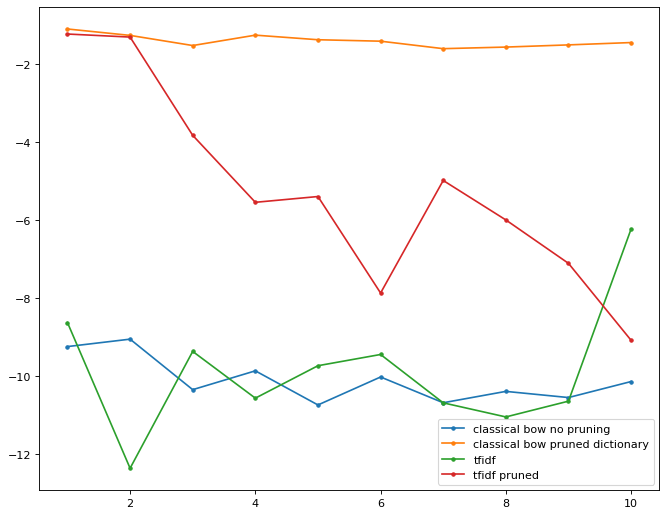

In [23]:
if take_measures:
    model_names = ['classical bow no pruning', 'classical bow pruned dictionary', 'tfidf', 'tfidf pruned']
    n_topics = [i for i in range(1,max_n_topics+1)]
    np.shape(coherency_scores)
    plt.figure(dpi=80, figsize = [10,8])
    for i in range(4):
        plt.plot(n_topics, coherency_scores[:,i], '.-', label = model_names[i])

    _ = plt.legend()
    _ = plt.show
    
    
    

In [10]:
lda_model = gensim.models.LdaMulticore(bow, num_topics=num_topics, id2word=dictionary, passes=10)

In [11]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_for_pruned_tfidf, num_topics=num_topics, id2word=pruned_dictionary_for_tfidf, passes=10)


Topic 0 keywords:

 format['word','frequency']

 [('cuore', 0.013369977), ('olga', 0.012878622), ('ricevere', 0.011640447), ('parere', 0.011273319), ('andare', 0.010073785), ('sera', 0.0095588), ('trovare', 0.008742409), ('sperare', 0.008650179), ('arrivare', 0.008410037), ('marcare', 0.008237441), ('venezia', 0.008117594), ('titina', 0.007687843), ('trieste', 0.007680695), ('venire', 0.0076477583), ('vedere', 0.0071438435), ('restare', 0.0069627967), ('credere', 0.00678824), ('notte', 0.006441878), ('baciare', 0.006230226), ('pensare', 0.0059661055)]


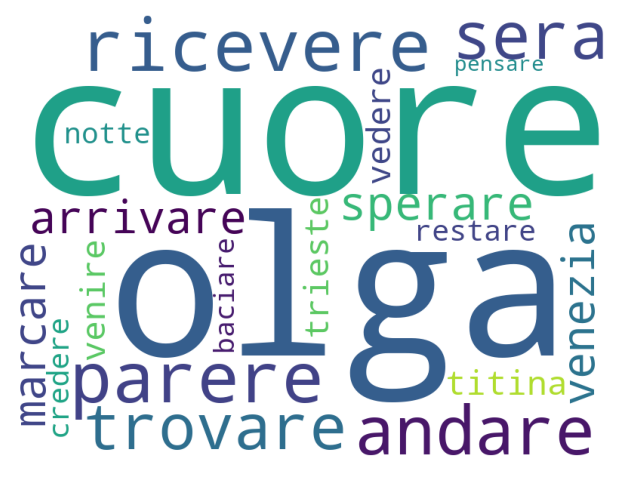

Topic 1 keywords:

 format['word','frequency']

 [('baciare', 0.0074848747), ('vedere', 0.0070223333), ('parlare', 0.006992135), ('trovare', 0.006775038), ('parola', 0.006428581), ('bisognare', 0.0061332914), ('pensare', 0.0061004013), ('londra', 0.005677782), ('restare', 0.0056294403), ('sentire', 0.005573534), ('parere', 0.0054591685), ('passare', 0.0052617155), ('inglese', 0.0051824204), ('credere', 0.0051417174), ('affare', 0.004829263), ('andare', 0.004595427), ('volere', 0.0045907777), ('dire', 0.0043494846), ('titina', 0.0043196133), ('leggere', 0.0042992076)]


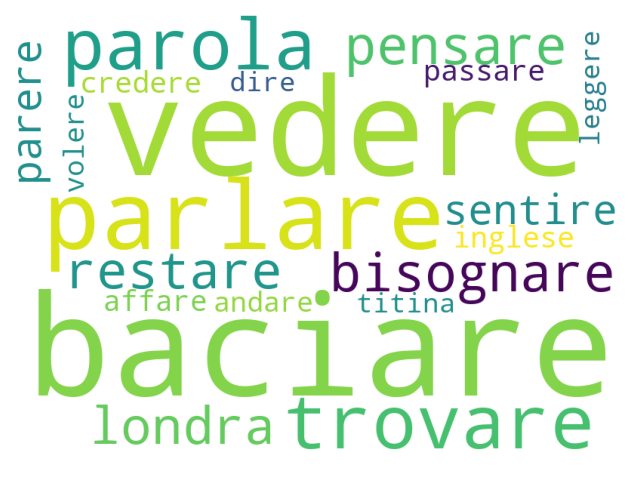

Topic 2 keywords:

 format['word','frequency']

 [('trieste', 0.012970133), ('credere', 0.011323633), ('amicare', 0.010143417), ('senilità', 0.010053674), ('parigi', 0.009094429), ('articolare', 0.00906293), ('mano', 0.008680289), ('librare', 0.008280497), ('sperare', 0.00792869), ('parere', 0.007509788), ('vedere', 0.0065443306), ('romanzare', 0.0064983494), ('veneziano', 0.006357778), ('ricevere', 0.0061720167), ('villa', 0.005755612), ('parlare', 0.0056308038), ('pensare', 0.005562879), ('zeno', 0.005273938), ('joyce', 0.005247622), ('crémieux', 0.0052064355)]


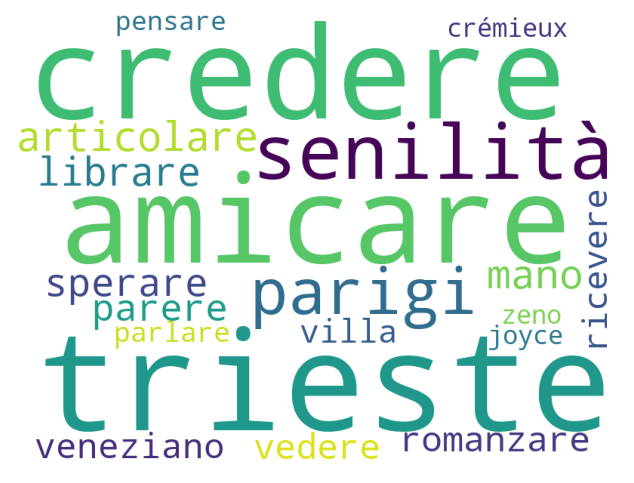

Topic 0:

['cuore', 'olga', 'ricevere', 'parere', 'andare', 'sera', 'trovare', 'sperare', 'arrivare', 'marcare', 'venezia', 'titina', 'trieste', 'venire', 'vedere', 'restare', 'credere', 'notte', 'baciare', 'pensare']

Topic 1:

['baciare', 'vedere', 'parlare', 'trovare', 'parola', 'bisognare', 'pensare', 'londra', 'restare', 'sentire', 'parere', 'passare', 'inglese', 'credere', 'affare', 'andare', 'volere', 'dire', 'titina', 'leggere']

Topic 2:

['trieste', 'credere', 'amicare', 'senilità', 'parigi', 'articolare', 'mano', 'librare', 'sperare', 'parere', 'vedere', 'romanzare', 'veneziano', 'ricevere', 'villa', 'parlare', 'pensare', 'zeno', 'joyce', 'crémieux']



In [12]:
key_words = extract_topic_keywords(lda_model, 20)

for i in range(len(key_words)):
    print("Topic {}:\n\n{}\n".format(i,key_words[i]))

In [13]:
scores = get_topic_scores(lda_model, bow)
letter_topics = list(map(np.argmax, scores))
ita_corpus['topic_scores'] = scores
ita_corpus['topic'] = letter_topics

In [14]:
people = []
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']

people = important_people
people.append('OTHER')

for person in people:
    sub_data_index = ita_corpus['SR'] == person
    sub_data = ita_corpus[sub_data_index]
    val_count = sub_data['topic'].value_counts()
    print("Person: {}".format(person))
    print("Topics")
    print(val_count)
    print("--- --- --- --- \n")

Person: Livia Veneziani
Topics
0    515
1     87
2      6
Name: topic, dtype: int64
--- --- --- --- 

Person: Eugenio Montale
Topics
2    62
Name: topic, dtype: int64
--- --- --- --- 

Person: Paul Henri Michel
Topics
2    17
Name: topic, dtype: int64
--- --- --- --- 

Person: Valerio Jahier
Topics
2    15
Name: topic, dtype: int64
--- --- --- --- 

Person: Marieanne Crémieux Comnène
Topics
2    14
Name: topic, dtype: int64
--- --- --- --- 

Person: James Joyce
Topics
2    13
Name: topic, dtype: int64
--- --- --- --- 

Person: Giuseppe Prezzolini
Topics
2    12
Name: topic, dtype: int64
--- --- --- --- 

Person: Ferdinando Pasini
Topics
2    11
Name: topic, dtype: int64
--- --- --- --- 

Person: Valéry Larbaud
Topics
2    11
Name: topic, dtype: int64
--- --- --- --- 

Person: OTHER
Topics
2    40
0    18
1     5
Name: topic, dtype: int64
--- --- --- --- 



In [15]:
year = ita_corpus['year']
min_y = min(year)
max_y = max(year)

In [16]:
topic_per_year = []
for y in range(min_y,max_y+1):
    counts = [0 for i in range(num_topics)]
    tpy = ita_corpus[ita_corpus['year'] == y]['topic']
    for topic in tpy:
        counts[topic] += 1 
    topic_per_year.append(counts)
    
        
    

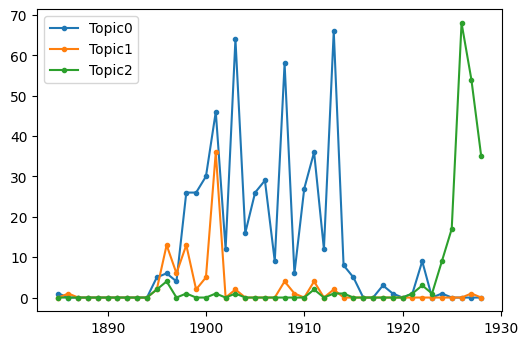

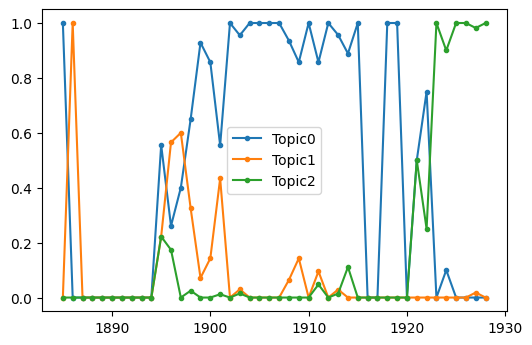

In [17]:
yy = [y for y in range(min_y,max_y+1)]
topic_per_year = np.array(topic_per_year, dtype = float)
plt.figure(dpi = 100)
for topic in range(num_topics):
    plt.plot(yy, topic_per_year[:,topic], '.-', label = "Topic" + str(topic))
plt.legend()
plt.figure(dpi = 100)

topic_per_year_norm = np.zeros_like(topic_per_year)

for i in range(len(topic_per_year)):
    if np.sum(topic_per_year[i,:]) != 0:
       
        topic_per_year_norm[i,:] = topic_per_year[i,:]/np.sum(topic_per_year[i,:])
        #print(np.sum(topic_per_year[i,:]), topic_per_year_norm[i,:])



for topic in range(num_topics):
    plt.plot(yy, topic_per_year_norm[:,topic], '.-', label = "Topic" + str(topic))
_ = plt.legend()

Are the identified topics understandable?

Are the topics coherent?

Does the topic model serve the purpose it is being used for?


Topic 0 keywords:

 format['word','frequency']

 [('cuore', 0.017521722), ('ricevere', 0.013867889), ('olga', 0.00985395), ('andare', 0.009815426), ('trovare', 0.009570527), ('baciare', 0.008955592), ('titina', 0.008522919), ('parere', 0.008469588), ('sera', 0.008378825), ('trieste', 0.008365463), ('marcare', 0.008207809), ('credere', 0.007050199), ('letizia', 0.006608979), ('vedere', 0.0064469776), ('leggere', 0.0058430606), ('parlare', 0.0057232105), ('sperare', 0.005653268), ('murare', 0.0054983418), ('viaggiare', 0.0053519867), ('notte', 0.0050042463)]


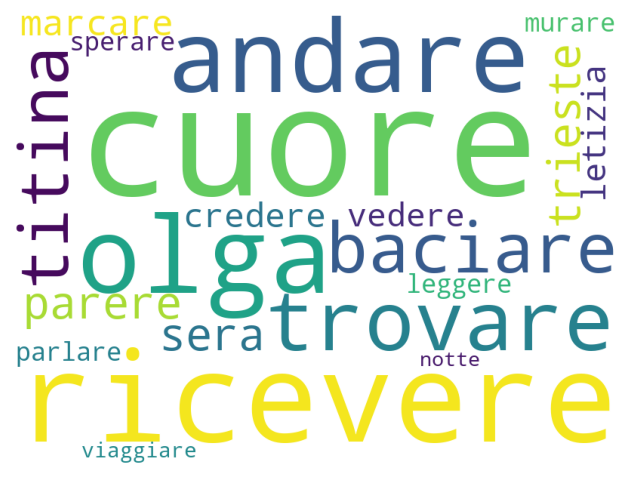

Topic 1 keywords:

 format['word','frequency']

 [('trieste', 0.013973687), ('credere', 0.010452715), ('amicare', 0.009721808), ('parigi', 0.00811806), ('articolare', 0.0075317905), ('mano', 0.006506268), ('librare', 0.0063816067), ('ricevere', 0.006210223), ('parlare', 0.0060811676), ('veneziano', 0.005857413), ('parere', 0.004903536), ('senilità', 0.0048142476), ('larbaud', 0.004612763), ('ricordare', 0.0045902343), ('vedere', 0.0045783943), ('sperare', 0.0045587406), ('parola', 0.0045317193), ('operare', 0.0043611103), ('trovare', 0.004188727), ('leggere', 0.004161203)]


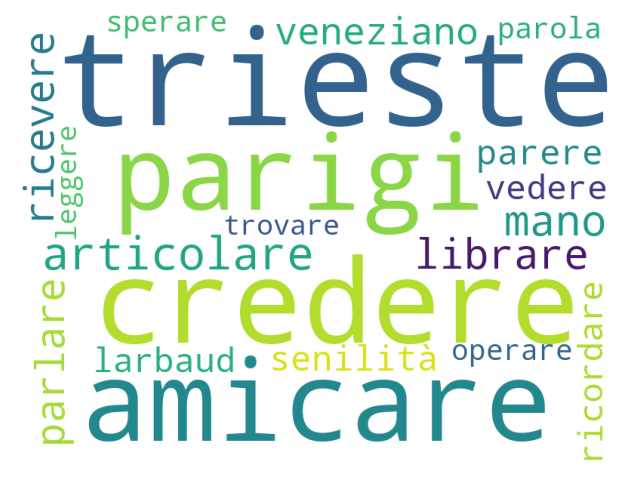

Topic 2 keywords:

 format['word','frequency']

 [('capra', 0.0031159609), ('tribel', 0.002384302), ('procedere', 0.0021585908), ('pom', 0.002144701), ('bontà', 0.0017744729), ('energia', 0.0016684489), ('fumare', 0.0016545339), ('sigaretta', 0.0015223364), ('onore', 0.001464017), ('dilazione', 0.0014538039), ('brunire', 0.0013607779), ('via', 0.00132549), ('mezzodì', 0.0013136615), ('amare', 0.0012987731), ('penna', 0.0012924725), ('vecio', 0.0012446805), ('lavorare', 0.0012381035), ('coda', 0.0012325598), ('dichiarare', 0.0012232643), ('cessare', 0.0011606029)]


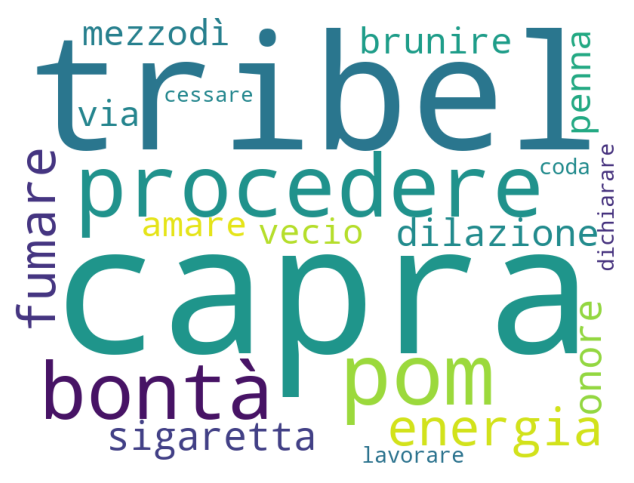

Topic 0:

['cuore', 'ricevere', 'olga', 'andare', 'trovare', 'baciare', 'titina', 'parere', 'sera', 'trieste', 'marcare', 'credere', 'letizia', 'vedere', 'leggere', 'parlare', 'sperare', 'murare', 'viaggiare', 'notte']

Topic 1:

['trieste', 'credere', 'amicare', 'parigi', 'articolare', 'mano', 'librare', 'ricevere', 'parlare', 'veneziano', 'parere', 'senilità', 'larbaud', 'ricordare', 'vedere', 'sperare', 'parola', 'operare', 'trovare', 'leggere']

Topic 2:

['capra', 'tribel', 'procedere', 'pom', 'bontà', 'energia', 'fumare', 'sigaretta', 'onore', 'dilazione', 'brunire', 'via', 'mezzodì', 'amare', 'penna', 'vecio', 'lavorare', 'coda', 'dichiarare', 'cessare']



In [18]:
key_words = extract_topic_keywords(lda_model_tfidf, 20)

for i in range(len(key_words)):
    print("Topic {}:\n\n{}\n".format(i,key_words[i]))

In [19]:
scores = get_topic_scores(lda_model_tfidf, bow_for_pruned_tfidf)
letter_topics = list(map(np.argmax, scores))
ita_corpus_tfidf['topic_scores'] = scores
ita_corpus_tfidf['topic'] = letter_topics

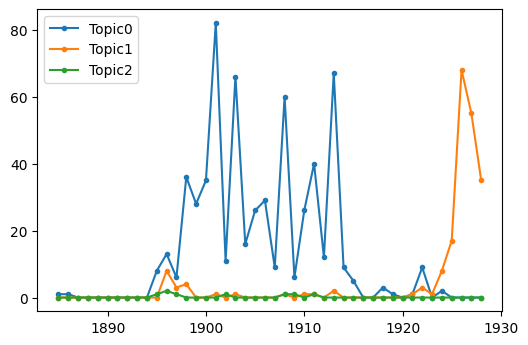

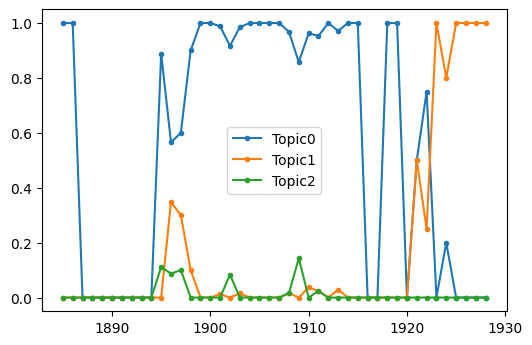

In [20]:
topic_per_year = []
for y in range(min_y,max_y+1):
    counts = [0 for i in range(num_topics)]
    tpy = ita_corpus_tfidf[ita_corpus_tfidf['year'] == y]['topic']
    for topic in tpy:
        counts[topic] += 1 
    topic_per_year.append(counts)


yy = [y for y in range(min_y,max_y+1)]
topic_per_year = np.array(topic_per_year, dtype = float)
plt.figure(dpi = 100)
for topic in range(num_topics):
    plt.plot(yy, topic_per_year[:,topic], '.-', label = "Topic" + str(topic))
plt.legend()
plt.figure(dpi = 100)

topic_per_year_norm = np.zeros_like(topic_per_year)

for i in range(len(topic_per_year)):
    if np.sum(topic_per_year[i,:]) != 0:
       
        topic_per_year_norm[i,:] = topic_per_year[i,:]/np.sum(topic_per_year[i,:])
        #print(np.sum(topic_per_year[i,:]), topic_per_year_norm[i,:])



for topic in range(num_topics):
    plt.plot(yy, topic_per_year_norm[:,topic], '.-', label = "Topic" + str(topic))
_ = plt.legend()

In [21]:
people = []
important_people = ['Livia Veneziani','Eugenio Montale','Paul Henri Michel','Valerio Jahier','Marieanne Crémieux Comnène','James Joyce','Giuseppe Prezzolini','Ferdinando Pasini','Valéry Larbaud']

people = important_people
people.append('OTHER')

for person in people:
    sub_data_index = ita_corpus_tfidf['SR'] == person
    sub_data = ita_corpus_tfidf[sub_data_index]
    val_count = sub_data['topic'].value_counts()
    print("Person: {}".format(person))
    print("Topics")
    print(val_count)
    print("--- --- --- --- \n")

Person: Livia Veneziani
Topics
0    584
1     19
2      5
Name: topic, dtype: int64
--- --- --- --- 

Person: Eugenio Montale
Topics
1    62
Name: topic, dtype: int64
--- --- --- --- 

Person: Paul Henri Michel
Topics
1    17
Name: topic, dtype: int64
--- --- --- --- 

Person: Valerio Jahier
Topics
1    15
Name: topic, dtype: int64
--- --- --- --- 

Person: Marieanne Crémieux Comnène
Topics
1    14
Name: topic, dtype: int64
--- --- --- --- 

Person: James Joyce
Topics
1    13
Name: topic, dtype: int64
--- --- --- --- 

Person: Giuseppe Prezzolini
Topics
1    12
Name: topic, dtype: int64
--- --- --- --- 

Person: Ferdinando Pasini
Topics
1    11
Name: topic, dtype: int64
--- --- --- --- 

Person: Valéry Larbaud
Topics
1    11
Name: topic, dtype: int64
--- --- --- --- 

Person: OTHER
Topics
1    36
0    24
2     3
Name: topic, dtype: int64
--- --- --- --- 

